In [2]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")
sys.path.append("../")
import os
import numpy as np
from hwr_utils import *
from hwr_utils.stroke_plotting import *
from hwr_utils.stroke_recovery import *
import json
from gen_preds_offline import load_all_gts

from hwr_utils import visualize
from torch.utils.data import DataLoader
from loss_module.stroke_recovery_loss import StrokeLoss
from trainers import TrainerStrokeRecovery
from hwr_utils.stroke_dataset import BasicDataset
from hwr_utils.stroke_recovery import *
from hwr_utils import utils
from torch.optim import lr_scheduler
from models.stroke_model import StrokeRecoveryModel
from train_stroke_recovery import parse_args, graph
from hwr_utils.hwr_logger import logger
from pathlib import Path

In [3]:
global epoch, device, trainer, batch_size, output, loss_obj, x_relative_positions, config, LOGGER
torch.cuda.empty_cache()

PROJ_ROOT = "/media/data/GitHub/simple_hwr/"
config_path = "/media/data/GitHub/simple_hwr/configs/stroke_config/ver5/normal_v3.yaml"
load_path_override = "/media/data/GitHub/simple_hwr/RESULTS/pretrained/new_best/good.pt"
load_path_override = "/media/data/GitHub/simple_hwr/RESULTS/pretrained/dtw_train_2.9/normal_preload_model.pt"

_load_path_override = Path(load_path_override)

OUTPUT = PROJ_ROOT / Path("RESULTS/OFFLINE_PREDS/") / _load_path_override.stem
OUTPUT.mkdir(parents=True, exist_ok=True)

# Make these the same as whereever the file is being loaded from; make the log_dir and results dir be a subset
# main_model_path, log_dir, full_specs, results_dir, load_path


config = utils.load_config(config_path, hwr=False, results_dir_override=OUTPUT.as_posix())

# Free GPU memory if necessary
if config.device == "cuda":
    utils.kill_gpu_hogs()

batch_size = config.batch_size

vocab_size = config.vocab_size

device=torch.device(config.device)
#device=torch.device("cpu")

#output = utils.increment_path(name="Run", base_path=Path("./results/stroke_recovery"))
output = Path(config.results_dir)
output.mkdir(parents=True, exist_ok=True)
folder = Path(config.dataset_folder)

# OVERLOAD
folder = PROJ_ROOT / Path("data/prepare_IAM_Lines/lines/")
gt_path = PROJ_ROOT / Path("data/prepare_IAM_Lines/gts/lines/txt")
#folder = Path(r"fish:////taylor@localhost:2222/media/data/GitHub/simple_hwr/data/prepare_IAM_Lines/")
#folder = Path("/media/data/GitHub/simple_hwr/data/prepare_IAM_Lines/words")
model = StrokeRecoveryModel(vocab_size=vocab_size, device=device, cnn_type=config.cnn_type, first_conv_op=config.coordconv, first_conv_opts=config.coordconv_opts).to(device)

## Loader
logger.info(("Current dataset: ", folder))
# Dataset - just expecting a folder
eval_dataset=BasicDataset(root=folder, cnn=model.cnn)

eval_loader=DataLoader(eval_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=6,
                              collate_fn=eval_dataset.collate, # this should be set to collate_stroke_eval
                              pin_memory=False)
config.n_train_instances = None
config.n_test_instances = len(eval_loader.dataset)
config.n_test_points = None

## Stats
config.use_visdom = False
if config.use_visdom:
    visualize.initialize_visdom(config["full_specs"], config)
utils.stat_prep_strokes(config)

# Create loss object
config.loss_obj = StrokeLoss(loss_names=config.loss_fns, loss_stats=config.stats, counter=config.counter)
optimizer = torch.optim.Adam(model.parameters(), lr=.0005 * batch_size/32)
config.scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=.95)
trainer = TrainerStrokeRecovery(model, optimizer, config=config, loss_criterion=config.loss_obj)

config.model = model
config.load_path = load_path_override if ("load_path_override" in locals()) else config.load_path

config.sigmoid_indices = TrainerStrokeRecovery.get_indices(config.pred_opts, "sigmoid")

# Load the GTs
GT_DATA = load_all_gts(gt_path)
print("Number of images: {}".format(len(eval_loader.dataset)))
print("Number of GTs: {}".format(len(GT_DATA)))

## LOAD THE WEIGHTS
utils.load_model_strokes(config) # should be load_model_strokes??????
model = model.to(device)
model.eval()

/media/data/GitHub/simple_hwr/configs/stroke_config/ver5/normal_v3.yaml
Experiment: new_experiment02, Results Directory: /home/taylor/github/simple_hwr/RESULTS/ver5/March 10/new_experiment02
Effective logging level: 20
Using config file /media/data/GitHub/simple_hwr/configs/stroke_config/ver5/normal_v3.yaml
| ID | GPU  | MEM |
-------------------
|  0 |   0% |  2% |
|  1 | nan% | 52% |
Creating LSTM: in:1024 hidden:128 dropout:0.5 layers:2 out:4
16:36:15 INFO COORD CONV: y_rel
16:36:15 INFO Zero center False
16:36:15 INFO RECT X Coord: False
16:36:15 INFO Normalized X Coord: True
16:36:15 INFO Using ABS+REL X Coord Channels: False
16:36:15 INFO X: False
16:36:15 INFO Y: False


../../hwr_utils/utils.py:33: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  return fix_scientific_notation(yaml.load(config.open(mode="r")))
/home/taylor/anaconda3/envs/hwr5/lib/python3.8/site-packages/torch/cuda/__init__.py:134: UserWarning: 
    Found GPU1 GeForce GTX 660 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


16:36:17 INFO ('Current dataset: ', PosixPath('/media/data/GitHub/simple_hwr/data/prepare_IAM_Lines/lines'))
{'Actual_Loss_Function_train': {'y': [None], 'x': [0], 'current_weight': 0, 'current_sum': 0, 'accumlator_active': False, 'updated_since_plot': False, 'accumulator_freq': None, 'x_title': 'Epochs', 'y_title': 'Loss', 'ymax': None, 'name': 'Actual_Loss_Function_train', 'plot': True, 'plot_update_length': 1, 'last_weight_step': 0, 'x_counter': <hwr_utils.stattrack.Counter object at 0x7efd082fd0a0>, 'x_weight': 'training_pred_count', 'x_plot': 'epoch_decimal', 'train': True}, 'nn_train': {'y': [None], 'x': [0], 'current_weight': 0, 'current_sum': 0, 'accumlator_active': False, 'updated_since_plot': False, 'accumulator_freq': None, 'x_title': 'Epochs', 'y_title': 'Loss', 'ymax': None, 'name': 'nn_train', 'plot': True, 'plot_update_length': 1, 'last_weight_step': 0, 'x_counter': <hwr_utils.stattrack.Counter object at 0x7efd082fd0a0>, 'x_weight': 'training_pred_count', 'x_plot': 'epoc

../../hwr_utils/utils.py:792: UserWarning: Could not load from all_stats.json
  warnings.warn("Could not load from all_stats.json")


StrokeRecoveryModel(
  (rnn): BidirectionalRNN(
    (rnn): LSTM(1024, 128, num_layers=2, dropout=0.5, bidirectional=True)
    (embedding): Linear(in_features=256, out_features=4, bias=True)
  )
  (cnn): CNN(
    (pool): MaxPool2d(kernel_size=3, stride=(4, 1), padding=1, dilation=1, ceil_mode=False)
    (cnn): Sequential(
      (conv0): CoordConv(
        (addcoords): AddCoords()
        (conv): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (relu0): ReLU(inplace=True)
      (pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu1): ReLU(inplace=True)
      (pooling1): MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [16]:

def eval_only(dataloader, model):
    final_out = []
    for i, item in enumerate(dataloader):
        preds = TrainerStrokeRecovery.eval(item["line_imgs"], model,
                                           label_lengths=item["label_lengths"],
                                           relative_indices=config.pred_relativefy,
                                           sigmoid_activations=config.sigmoid_indices)

        # Pred comes out of eval WIDTH x VOCAB
        preds_to_graph = [post_process(p, item["line_imgs"][i]).transpose(1,0) for i,p in enumerate(preds)]
        globals().update(locals())
        # Get GTs, save to file
        if i<10:
            # Save a sample
            save_folder = graph(item, preds=preds_to_graph, _type="eval", epoch="current", config=config, save_folder=None)
            output_path = (Path(save_folder) / "data")
            output_path.mkdir(exist_ok=True, parents=True)

        names = [Path(p).stem.lower() for p in item["paths"]]
        output = []
        for ii, name in enumerate(names):
            if name in GT_DATA:
                output.append({"stroke": preds[ii].detach().numpy(), "text":GT_DATA[name]})
            else:
                print(f"{name} not found")
        utils.pickle_it(output, output_path / f"{i}.pickle")
        np.save(output_path / f"{i}.npy", output)
        final_out += output
        STOP
    utils.pickle_it(final_out, output_path / f"all_data.pickle")
    np.save(output_path / f"all_data.npy", final_out)


In [ ]:
def post_process(pred,gt):
    return move_bad_points(reference=gt, moving_component=pred, reference_is_image=True)

def preserve_deleted_start_points(moving_component, proposed_deletion_indices):
    lost_start_points = np.argwhere(np.round(moving_component[proposed_deletion_indices][:,2]))
    lost_start_points = proposed_deletion_indices[lost_start_points]
    
    output_start_point_indices = []
    _temp_output_start_point_indices = lost_start_points+1
    for i in _temp_output_start_point_indices.flatten().tolist():
        while i in proposed_deletion_indices: # make sure that index is not going to be deleted
            i+=1
        if i < moving_component.shape[0]:
            output_start_point_indices.append(i)
    #globals().update(locals())
    return list(set(output_start_point_indices))

def move_bad_points(reference, moving_component, reference_is_image=True, max_distance=.04, **kwargs):

    # JUST FOR GRAPHING
    item = {"line_imgs":[reference[:,:1000]], "paths":[""]}
    preds = moving_component.clone().detach().numpy()
    plt.figure(dpi=300)
    print("Before fix")
    graph(item, preds=[preds.copy().transpose([1, 0])], _type="eval", epoch="current", config=config, save_folder=None, plot_points=False, show=True)
    
    
    nearest_points, distances = get_nearest_point(reference, moving_component, reference_is_image, **kwargs)
    if isinstance(moving_component, Tensor):
        moving_component = moving_component.detach().numpy()
    moving_component[:,0:2] = nearest_points

    # Collapse start points a bit
    proposed_deletion_indices = np.argwhere(distances >= max_distance).flatten()
    new_start_points = preserve_deleted_start_points(moving_component, proposed_deletion_indices)
    moving_component[new_start_points,2] = 1
    output = np.delete(moving_component, proposed_deletion_indices, axis=0)

    #output = moving_component[distances < max_distance]
    
    #globals().update(locals())
    graph(item, preds=[output.copy().transpose([1, 0])], _type="eval", epoch="current", config=config, save_folder=None, plot_points=False, show=True)

    return output

# preds_to_graph =  [p.numpy().transpose([1, 0]) for i,p in enumerate(preds)]
# graph(item, preds=preds_to_graph, _type="eval", epoch="current", config=config, save_folder=None)

In [ ]:
print(proposed_deletion_indices)

In [ ]:
print(output_start_point_indices)

In [13]:
def post_process(pred,gt):
    return make_more_starts(move_bad_points(reference=gt, moving_component=pred, reference_is_image=True), max_dist=.15)


saving None


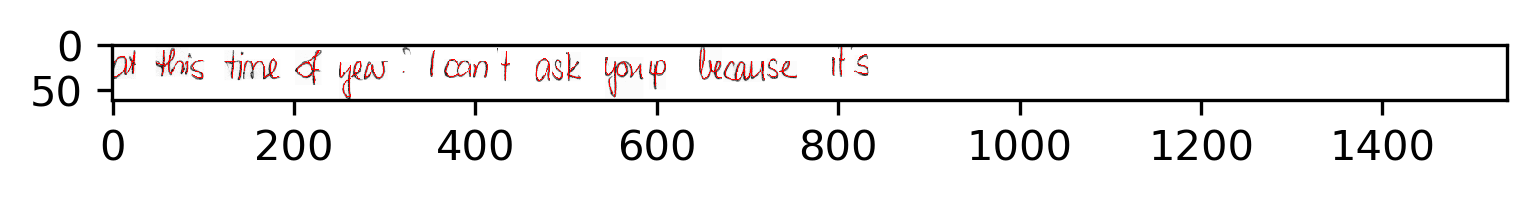

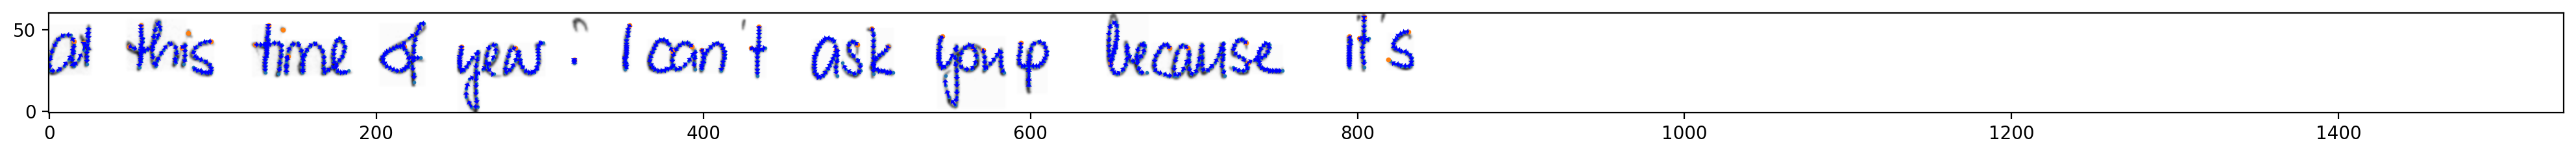

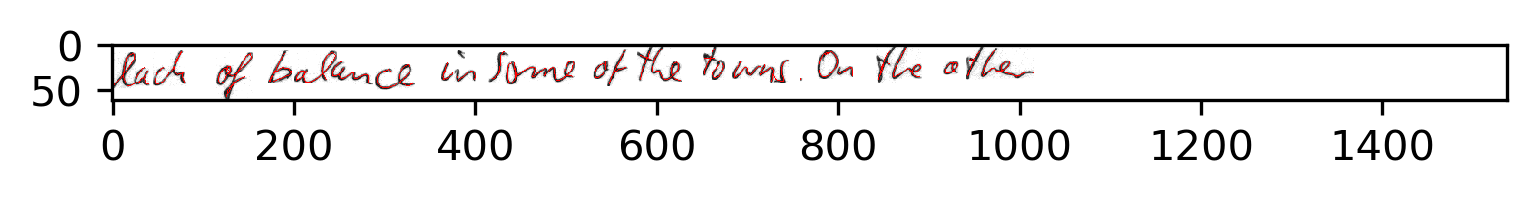

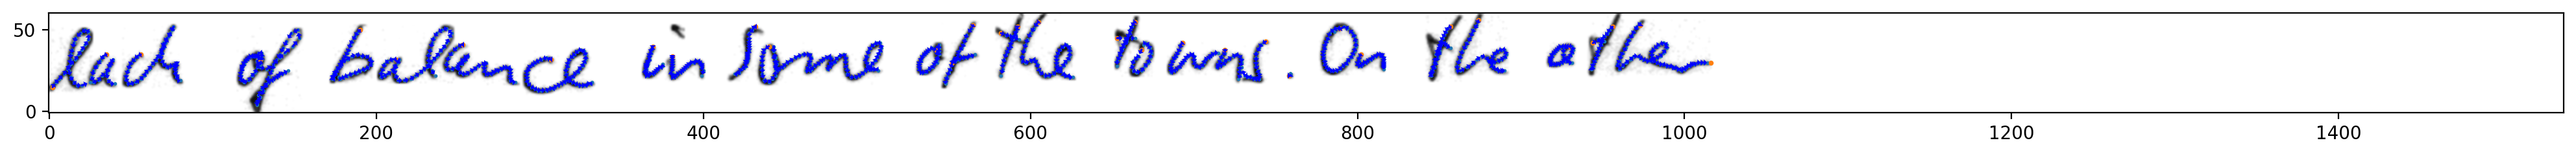

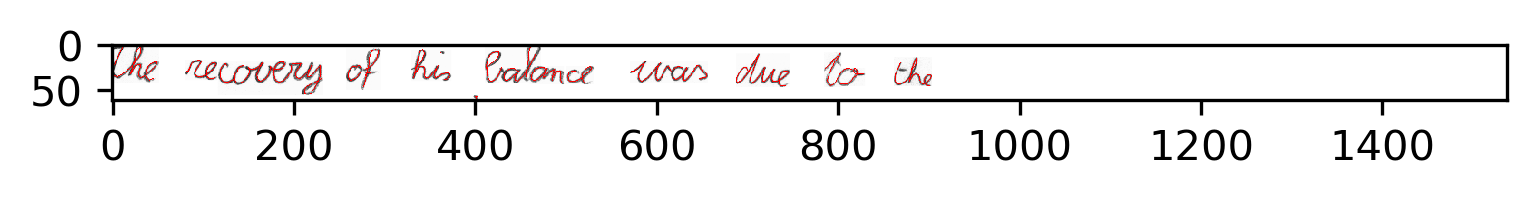

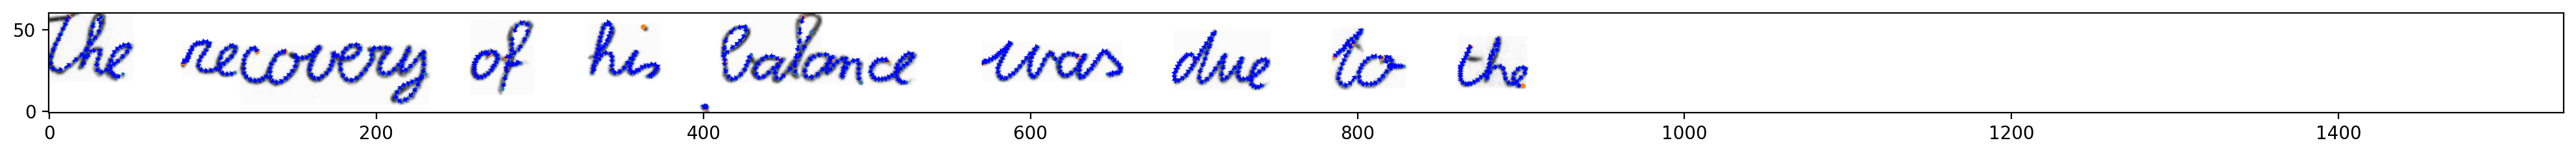

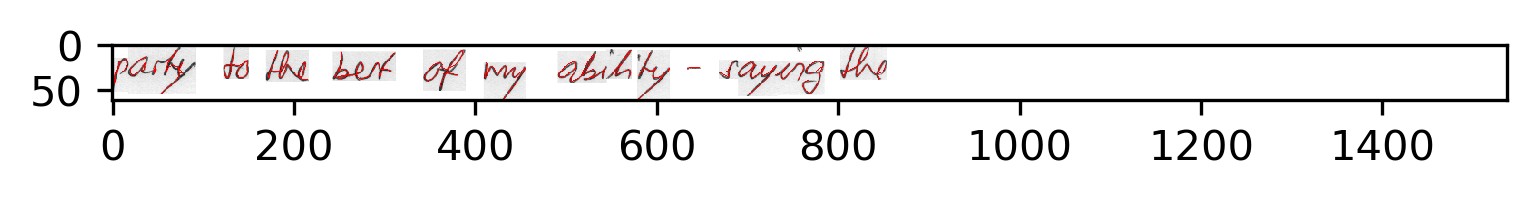

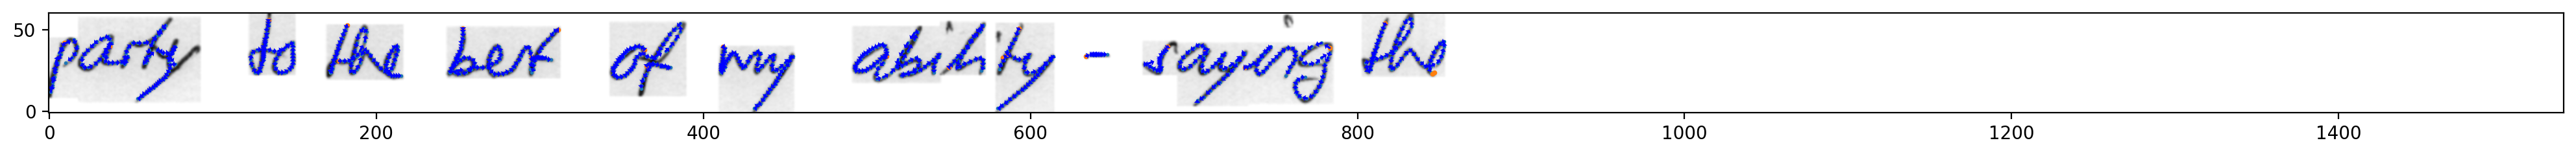

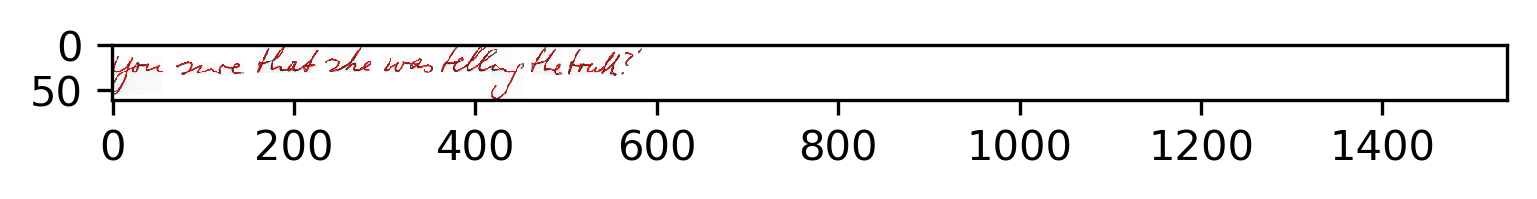

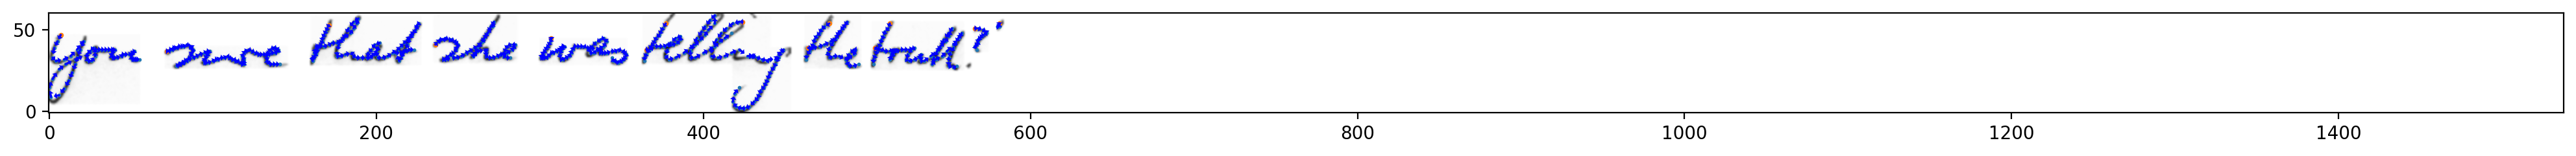

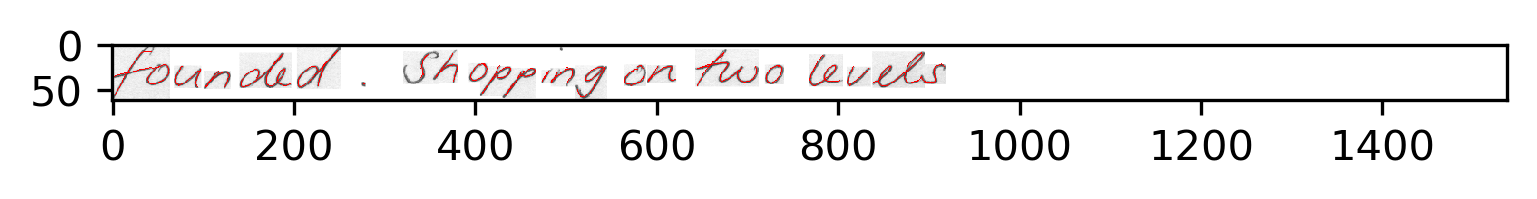

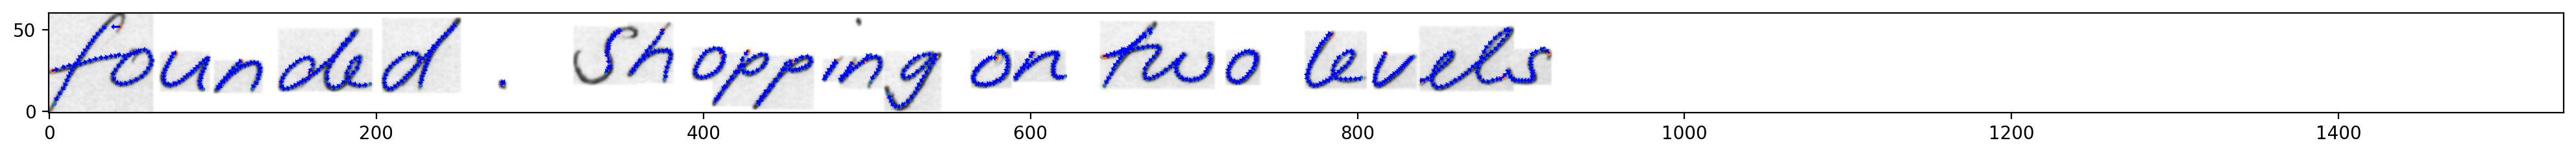

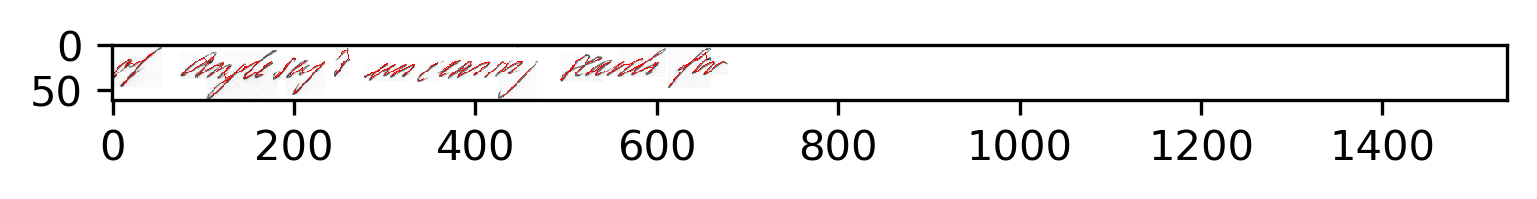

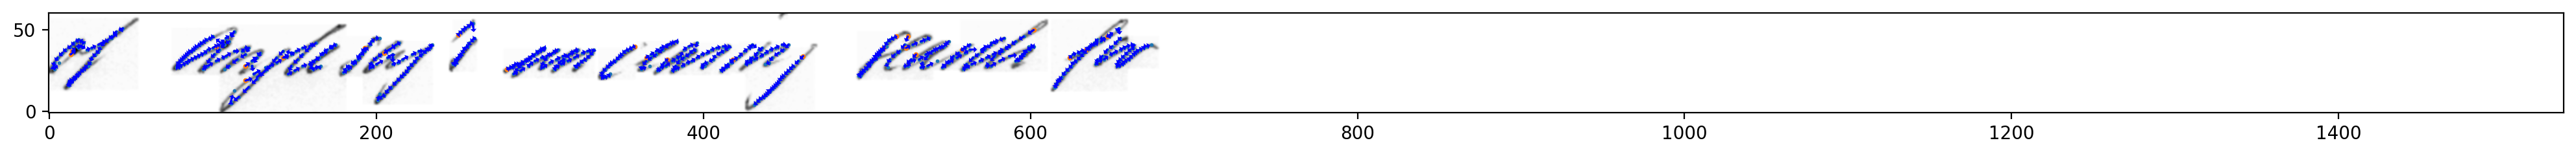

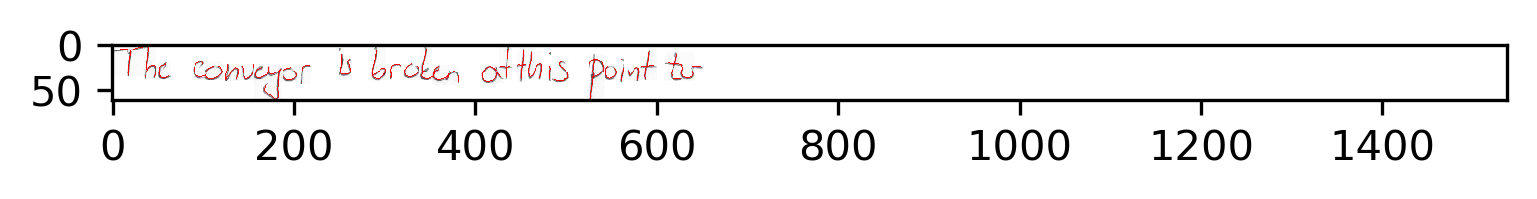

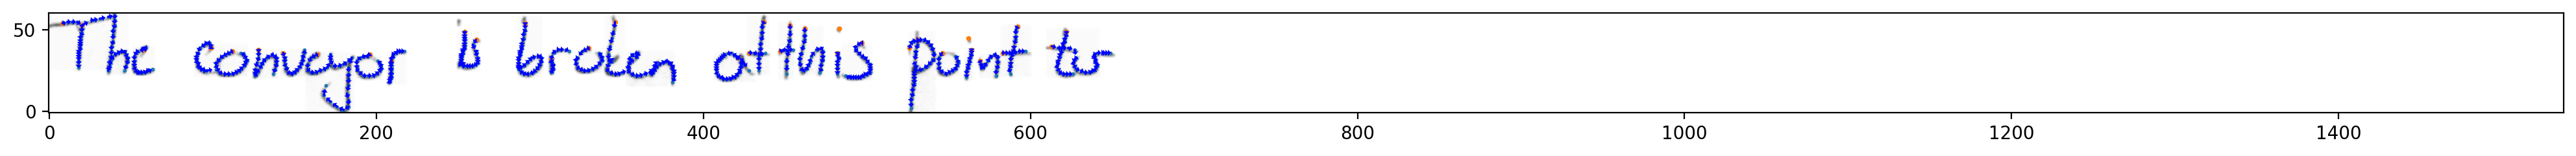

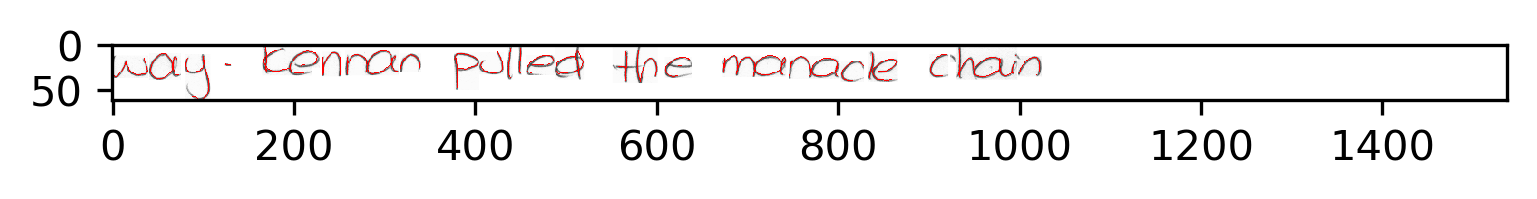

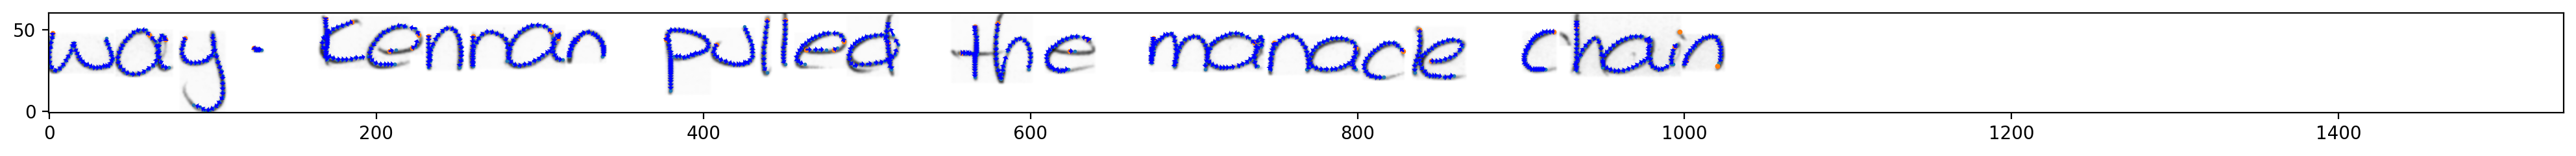

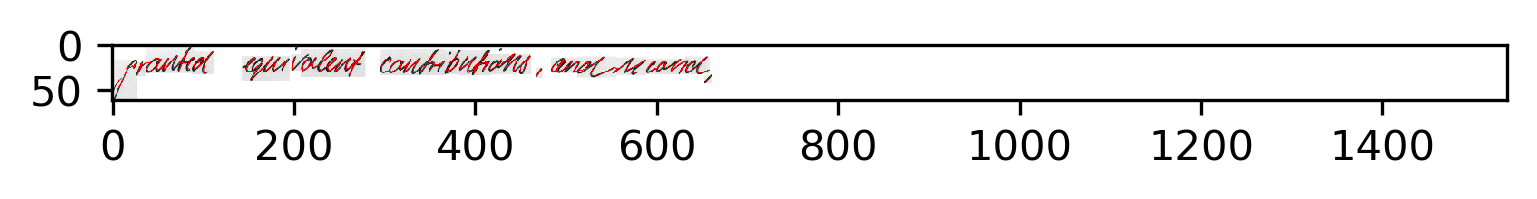

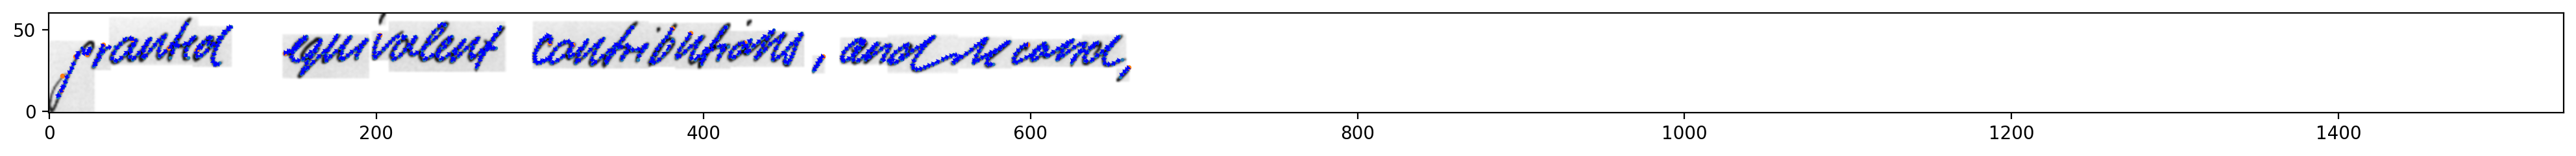

TypeError: expected str, bytes or os.PathLike object, not NoneType

In [17]:
eval_only(eval_loader, model)

In [ ]:
# [post_process(p, item["line_imgs"][i]).permute([1, 0]) for i,p in enumerate(preds)]
print(preds[0])
#print(preds_to_graph[0])
# print(preds_to_graph)


In [ ]:
i = np.squeeze(item["line_imgs"][0].numpy())
print(i.shape)

In [ ]:
from matplotlib import pyplot as plt
plt.figure(dpi=300)
plt.imshow(np.squeeze(i), cmap="gray")

p = preds[0].transpose(1,0).numpy() * 61 * (1-6.5/61)
plot_stroke_points(p[0],p[1],p[2])
plt.scatter(p[0],61-p[1], s=1)
plt.show()

In [ ]:
render_points_on_image(gts=preds[0], img=i , save_path=None, origin='lower', invert_y_image=True)

In [ ]:
from easydict import EasyDict as edict
#config = edict({"model_name":"normal"})
#graph(item, config=config, preds=preds, _type="test", save_folder=None, epoch="current", show=False)


# for i,p in enumerate(preds):
#     x = post_process(pred=p.numpy(), gt=np.squeeze(item["line_imgs"][i]))
#     print(x.shape)

preds_to_graph2 = [post_process(p.numpy(), np.squeeze(item["line_imgs"][i])).transpose([1, 0]) for i,p in enumerate(preds)]
graph(item, preds=preds_to_graph2, _type="eval", epoch="current", config=config, save_folder=None, show=True)

In [ ]:
preds_to_graph =  [p.numpy().transpose([1, 0]) for i,p in enumerate(preds)]
graph(item, preds=preds_to_graph, _type="eval", epoch="current", config=config, save_folder=None)

In [ ]:
from hwr_utils.stroke_recovery import make_more_starts, move_bad_points

def post_process(pred,gt):
    #return pred
    return make_more_starts(move_bad_points(reference=gt, moving_component=pred, reference_is_image=True))

# for i,p in enumerate(preds):
#     x = post_process(pred=p.numpy(), gt=np.squeeze(item["line_imgs"][i]))
#     print(x.shape)

preds_to_graph3 = [post_process(p.numpy(), np.squeeze(item["line_imgs"][i])).transpose([1, 0]) for i,p in enumerate(preds)]
graph(item, preds=preds_to_graph3, _type="eval", epoch="current", config=config, save_folder=None)

In [ ]:
_min = 1000
item = ""
for i in dataloader:
    new_min = np.min(i["label_lengths"])
    _min = min(new_min, _min)
    if _min == new_min:
        item = i
print(_min)


In [ ]:
_max = 0
item = ""
for i in dataloader:
    new_max = np.max(i["label_lengths"])
    _max = max(new_max, _max)
    if _max == new_max:
        item = i
print(_max)

In [ ]:
lens = []
for i in dataloader:
    lens+=i["label_lengths"]
plt.hist(lens)

In [ ]:
plt.figure(dpi=300)
m = np.squeeze(item["line_imgs"][7].numpy()[::-1])
plt.imshow(m)

In [ ]:
assert np.inf == np.inf and -1 < 0

In [ ]:
def plot_pred(pred, background=None, stroke_number=False):
    pred = utils.to_numpy(pred)
    if stroke_number:
        coords[2] = relativefy_numpy(coords[2], reverse=False)
        coords[2:, :] = np.round(coords[2:, :]) # VOCAB SIZE, LENGTH
    # Red images
    bg = overlay_images(background, foreground_gt=pred.transpose())

    plt.figure(dpi=300)
    plt.imshow(bg)
plt.close('all')
preds_to_graph3 = [post_process(p.numpy(), np.squeeze(item["line_imgs"][i])).transpose([1, 0]) for i,p in enumerate(preds)]
for i,p in enumerate(preds_to_graph3):
    background = np.squeeze(item["line_imgs"][i])
    _max = int(np.max(p[0])*61)
    plot_pred(p)
    plot_pred(p, background=background[:,:_max])
    

In [ ]:
import pickle
from pathlib import Path
import numpy as np
p = "/home/taylor/shares/brodie/github/simple_hwr/RESULTS/ver4/20200229_223630-stroke_number_with_BCE_RESUME/new_experiment04/20200307_101347-stroke_number_with_BCE_RESUME2/imgs/114/train/example_data.pickle"
output = pickle.load(Path(p).open("rb"))
print(output["preds"][0])

In [ ]:
import sys
np.set_printoptions(suppress=True)
np.set_printoptions(threshold=sys.maxsize)

m = output["preds"][0]

print(m.transpose())

In [ ]:
from matplotlib import pyplot as plt
x = np.linspace(-5,5,100)
y = lambda x: (2.71**x)/(2.71**x+1)

plt.plot(x,y(x))

In [ ]:
x = -3
print(y(x))

In [ ]:
x = np.array([1,2,2.4,3])
y = np.array([1,2,3.1,4])
x_max=x[-1]
x_min = x[-1]-1
args = np.argwhere((x >= x_min) & (x<=x_max))
np.mean(y[args])


In [ ]:
args = [[0,2]]
y = np.array([None, 5,4])

y[args][y[args] != np.array(None)]


In [ ]:
import re
for c in Path("/media/data/GitHub/handwriting-synthesis/checkpoints").glob("model-*"):
    x = re.findall("([0-9]+)", c.stem)[0]
    print(int(x))
print(c.stem)



In [3]:
import numpy as np
np.array(range(10))[np.array([3,5])]

array([3, 5])

In [5]:
for x in iter(zip([1,2,3,4],range(5,9))):
    print(x)

(1, 5)
(2, 6)
(3, 7)
(4, 8)
